# Dijet mass compression and decompression

In [1]:
import sys
import os
BIN = '../../../'
sys.path.append(BIN)
from my_nn_modules import AE_basic, AE_bn_LeakyReLU
from utils import plot_activations
from my_nn_modules import get_data, RMSELoss
from fastai import train as tr
from fastai.callbacks import ActivationStats
from fastai import basic_train, basic_data
from fastai.callbacks.tracker import SaveModelCallback
from torch.utils.data import TensorDataset
import torch.utils.data
import torch.nn as nn
import torch
import utils
from scipy import stats
import my_matplotlib_style as ms
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from my_nn_modules import AE_basic, AE_bn_LeakyReLU

import ROOT

mpl.rc_file(BIN + 'my_matplotlib_rcparams')

Welcome to JupyROOT 6.18/04


In [2]:
plt.close('all')

In [3]:
sample = 600
leading_df = pd.read_pickle(BIN + 'processed_data/mc/leading_%d.pkl' % sample)
subleading_df = pd.read_pickle(BIN + 'processed_data/mc/subleading_%d.pkl' % sample)

In [4]:
leading_df.keys()

Index(['pt', 'eta', 'phi', 'm', 'ActiveArea', 'ActiveArea4vec_eta',
       'ActiveArea4vec_m', 'ActiveArea4vec_phi', 'ActiveArea4vec_pt',
       'AverageLArQF', 'NegativeE', 'HECQuality', 'LArQuality', 'CentroidR',
       'DetectorEta', 'LeadingClusterCenterLambda', 'LeadingClusterPt',
       'LeadingClusterSecondLambda', 'LeadingClusterSecondR',
       'N90Constituents', 'EMFrac', 'HECFrac', 'Timing', 'OotFracClusters10',
       'OotFracClusters5'],
      dtype='object')

## Checking invariant mass before compression

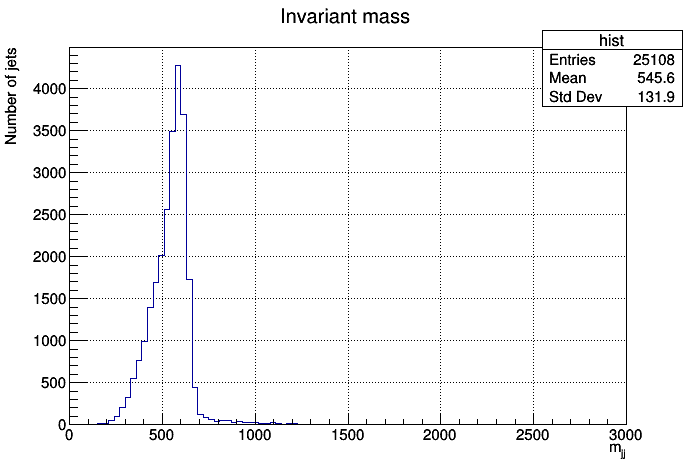

In [5]:
canv = ROOT.TCanvas("canv", "canvas")
hist = ROOT.TH1D("hist", "Invariant mass", 100, 0, 3000)

mjj_orig_list = []
for ii in np.arange(len(leading_df)):
    m1 = leading_df['m'][ii] / 1000
    m2 = subleading_df['m'][ii] / 1000
    pT1 = leading_df['pt'][ii] / 1000
    pT2 = subleading_df['pt'][ii] / 1000
    eta1 = leading_df['eta'][ii]
    eta2 = subleading_df['eta'][ii]
    phi1 = leading_df['phi'][ii]
    phi2 = subleading_df['phi'][ii]

    vec4_1 = ROOT.TLorentzVector()
    vec4_1.SetPtEtaPhiM(pT1, eta1, phi1, m1)
    vec4_2 = ROOT.TLorentzVector()
    vec4_2.SetPtEtaPhiM(pT2, eta2, phi2, m2)
    vec4_jj = vec4_1 + vec4_2

    mjj = vec4_jj.M()

    hist.Fill(mjj)
    mjj_orig_list.append(mjj)

hist.GetXaxis().SetTitle('m_{jj}')
hist.GetYaxis().SetTitle('Number of jets')
canv.SetGrid()
hist.Draw()
canv.Draw()

In [6]:
canv.Print("mjj_%d_original.pdf]" % sample)

Info in <TCanvas::Print>: pdf file mjj_600_original.pdf has been created


## Filter and normalize

In [7]:
utils.unit_convert_jets(leading_df, subleading_df)
#leading_df, subleading_df = utils.filter_mc_jets(leading_df, subleading_df)
#subleading_df, leading_df = utils.filter_mc_jets(subleading_df, leading_df)

In [8]:
leading_df

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,282.143906,0.357106,2.052783,17.815330,0.478719,0.387840,0.129280,2.034354,0.470565,43.899895,...,207.413467,184.662375,13.741747,4.770598,3.0,0.791751,0.000000,-0.064632,0.004992,0.004992
1,357.483812,-1.675359,2.656734,9.989503,0.498666,-1.704270,0.139503,2.663534,0.489469,13.800751,...,382.209137,312.535563,144.292266,8.149557,1.0,0.765181,0.222290,-0.063121,0.000000,0.000000
2,251.073391,-0.163035,-0.061511,17.186111,0.548532,-0.163706,0.161883,-0.089722,0.537609,63.227493,...,415.136780,197.359938,158.613781,10.674870,2.0,0.719836,0.000000,0.030196,0.000000,0.000000
3,227.642578,-1.656474,-3.009750,22.642111,0.498666,-1.685798,0.139847,-3.007620,0.488680,49.186981,...,385.130371,96.635070,122.919695,6.571641,4.0,0.595289,0.364340,0.349498,0.001380,0.028172
4,244.356875,-0.707400,0.262679,13.551034,0.508639,-0.715531,0.141122,0.253727,0.499525,14.949917,...,719.343323,216.613359,405.694594,29.656051,1.0,0.630272,0.000000,0.017330,0.000000,0.003572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25103,320.144875,-0.568237,-0.154590,17.803051,0.528585,-0.592095,0.150236,-0.167252,0.516959,26.974510,...,263.200409,150.725188,51.208937,6.694298,3.0,0.621394,0.000000,0.008076,0.008696,0.008696
25104,217.378656,0.421524,-0.206758,15.371303,0.518612,0.421954,0.144203,-0.200050,0.508664,27.048975,...,334.723633,187.618937,135.312609,7.579952,1.0,0.909646,0.000000,-0.071890,0.000000,0.004819
25105,212.672297,-1.083554,1.317620,20.211252,0.468746,-1.098738,0.127954,1.330715,0.460240,48.402004,...,392.938538,102.633070,38.350109,7.348679,5.0,0.748143,0.000000,-0.078537,0.007331,0.007331
25106,205.712109,1.968570,0.894979,14.134563,0.558505,2.012528,0.160647,0.908536,0.547760,140.339035,...,207.031555,71.464883,10.814205,1.380502,5.0,0.732184,0.266894,0.046275,0.000000,0.000000


In [9]:
# Filter jets and normalize
#utils.filter_mc_jets(leading_df, subleading_df)
#utils.filter_mc_jets(subleading_df, leading_df)
leading_df, subleading_df = utils.custom_normalization(leading_df, subleading_df)

Wdith not found when normalizing
WdithPhi not found when normalizing
Wdith not found when normalizing
WdithPhi not found when normalizing


In [10]:
leading_df

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,0.958726,0.071421,0.684261,0.708062,0.598399,0.077568,0.568220,0.678118,0.672236,0.063224,...,0.243861,1.888649,0.055920,0.033732,0.15,0.494844,0.000000,-0.001616,0.007209,0.007209
1,1.044380,-0.335072,0.885578,0.578321,0.623332,-0.340854,0.625017,0.887845,0.699241,0.022458,...,0.341618,2.079083,0.387910,0.056708,0.05,0.478238,0.222290,-0.001578,0.000000,0.000000
2,0.916501,-0.032607,-0.020504,0.699855,0.685665,-0.032741,0.749350,-0.029907,0.768013,0.085117,...,0.355961,1.912716,0.412652,0.073415,0.10,0.449897,0.000000,0.000755,0.000000,0.000000
3,0.881045,-0.331295,-1.003250,0.763159,0.623332,-0.337160,0.626927,-1.002540,0.698114,0.069492,...,0.342929,1.654279,0.348148,0.046069,0.20,0.372056,0.364340,0.008737,0.001997,0.040219
4,0.906687,-0.141480,0.087560,0.646052,0.635798,-0.143106,0.634012,0.084576,0.713607,0.024203,...,0.456733,1.946404,0.703888,0.187988,0.05,0.393920,0.000000,0.000433,0.000000,0.005162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25103,1.004455,-0.113647,-0.051530,0.707905,0.660732,-0.118419,0.684643,-0.055751,0.738513,0.041487,...,0.280073,1.815155,0.179577,0.046902,0.15,0.388371,0.000000,0.000202,0.012534,0.012534
25104,0.864347,0.084305,-0.068919,0.674491,0.648265,0.084391,0.651127,-0.066683,0.726663,0.041588,...,0.319107,1.894397,0.371645,0.052886,0.05,0.568529,0.000000,-0.001797,0.000000,0.006959
25105,0.856426,-0.216711,0.439207,0.736981,0.585932,-0.219748,0.560854,0.443572,0.657486,0.068576,...,0.346396,1.676073,0.140980,0.051328,0.25,0.467589,0.000000,-0.001963,0.010575,0.010575
25106,0.844383,0.393714,0.298326,0.655539,0.698132,0.402506,0.742483,0.302845,0.782514,0.152330,...,0.243592,1.545077,0.044595,0.009924,0.25,0.457615,0.266894,0.001157,0.000000,0.000000


## Load trained model

In [11]:
latent_dim = 18

bs = 4096
# Create TensorDatasets
leading_ds = TensorDataset(torch.tensor(leading_df.values, dtype=torch.float),
                         torch.tensor(leading_df.values, dtype=torch.float))
subleading_ds = TensorDataset(torch.tensor(subleading_df.values, dtype=torch.float),
                         torch.tensor(subleading_df.values, dtype=torch.float))

# Create DataLoaders
train_dl, valid_dl = get_data(subleading_ds, subleading_ds, bs=bs)
# Return DataBunch
db = basic_data.DataBunch(train_dl, valid_dl)

module_name = 'AE_bn_LeakyReLU'
module = AE_bn_LeakyReLU

grid_search_folder = module_name + '_25AOD_grid_search_custom_normalization_1500epochs/'
# grid_search_folder = module_name + '_AOD_grid_search_custom_normalization_1500epochs_12D10D8D/'
model_folder = 'AE_25_200_200_200_%d_200_200_200_25' % latent_dim
#train_folder = 'AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02_ppNA'  # z=20
train_folder = 'AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02_ppNA'  # z=18
#train_folder = 'AE_bn_LeakyReLU_bs4096_lr3e-02_wd1e-04_ppNA'  # z=16
#train_folder = 'AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02_ppNA'  # z=14
#train_folder = 'AE_bn_LeakyReLU_bs4096_lr1e-03_wd1e-01_ppNA'  # z=12 
#train_folder = 'AE_bn_LeakyReLU_bs4096_lr1e-03_wd1e-02_ppNA'  # z=10
#train_folder = 'AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-04_ppNA'  # z=8

save = True

loss_func = nn.MSELoss()


plt.close('all')
tmp = train_folder.split('bs')[1]
param_string = 'bs' + tmp
save_dict_fname = 'save_dict' + param_string + '.pkl'
path_to_save_dict = grid_search_folder + model_folder + '/' + train_folder + '/' + save_dict_fname
saved_model_fname = 'best_' + module_name + '_' + param_string.split('_pp')[0]
path_to_saved_model = model_folder + '/' + 'models/' + saved_model_fname
curr_save_folder = model_folder + '/' + train_folder + '/'


nodes = model_folder.split('AE_')[1].split('_')
nodes = [int(x) for x in nodes]
model = module(nodes)
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, true_wd=True, bn_wd=False,)
learn.model_dir = model_folder + '/' + 'models/'
learn.load(saved_model_fname)
learn.model.eval()

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=25, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=18, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=Tru

## Compress, decompress, evaluate

In [12]:
def get_predictions(df, idxs=(0, -1)):
    data = torch.tensor(df[idxs[0]:idxs[1]].values, dtype=torch.float)
    pred = model(data).detach().numpy()
    data = data.detach().numpy()

    data_df = pd.DataFrame(data, columns=df.columns)
    pred_df = pd.DataFrame(pred, columns=df.columns)

    # Unnormalize
    unnormalized_data_df = utils.custom_unnormalize(data_df)
    unnormalized_pred_df = utils.custom_unnormalize(pred_df)

    # Handle variables with discrete distributions
    unnormalized_pred_df['N90Constituents'] = unnormalized_pred_df['N90Constituents'].round()
    uniques = unnormalized_data_df['ActiveArea'].unique()
    utils.round_to_input(unnormalized_pred_df, uniques, 'ActiveArea')

    data = unnormalized_data_df.values
    pred = unnormalized_pred_df.values
    
    return data, pred, unnormalized_data_df, unnormalized_pred_df

In [13]:
data_leading, pred_leading, data_leading_df, pred_leading_df = get_predictions(leading_df)
data_subleading, pred_subleading, data_subleading_df, pred_subleading_df = get_predictions(subleading_df)

Width not found when unnormalizing
WidthPhi not found when unnormalizing
Width not found when unnormalizing
WidthPhi not found when unnormalizing
Width not found when unnormalizing
WidthPhi not found when unnormalizing
Width not found when unnormalizing
WidthPhi not found when unnormalizing


In [14]:
save = False

In [15]:
data_leading[:,0]

array([282.143913, 357.483802, 251.073387, 227.64257 , ..., 320.144862, 217.378645, 212.672293, 205.712124])

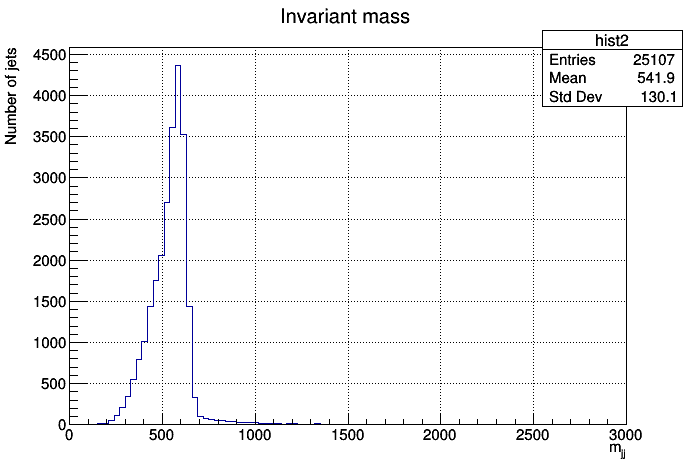

In [16]:
canv2 = ROOT.TCanvas("canv2", "canvas2")
hist2 = ROOT.TH1D("hist2", "Invariant mass", 100, 0, 3000)

mjj_z_list = []
for ii in np.arange(len(pred_leading_df)):
    m1 = pred_leading_df['m'].iloc[ii]
    m2 = pred_subleading_df['m'].iloc[ii]
    pT1 = pred_leading_df['pt'].iloc[ii]
    pT2 = pred_subleading_df['pt'].iloc[ii]
    eta1 = pred_leading_df['eta'].iloc[ii]
    eta2 = pred_subleading_df['eta'].iloc[ii]
    phi1 = pred_leading_df['phi'].iloc[ii]
    phi2 = pred_subleading_df['phi'].iloc[ii]

    vec4_1 = ROOT.TLorentzVector()
    vec4_1.SetPtEtaPhiM(pT1, eta1, phi1, m1)
    vec4_2 = ROOT.TLorentzVector()
    vec4_2.SetPtEtaPhiM(pT2, eta2, phi2, m2)
    vec4_jj = vec4_1 + vec4_2

    mjj = vec4_jj.M()

    hist2.Fill(mjj)
    mjj_z_list.append(mjj)
    
hist2.GetXaxis().SetTitle('m_{jj}')
hist2.GetYaxis().SetTitle('Number of jets')
canv2.SetGrid()
hist2.Draw()
canv2.Draw()

In [17]:
canv2.Print("mjj_%d_z%d_decompressed.pdf]" % (sample, latent_dim))

Info in <TCanvas::Print>: pdf file mjj_600_z18_decompressed.pdf has been created


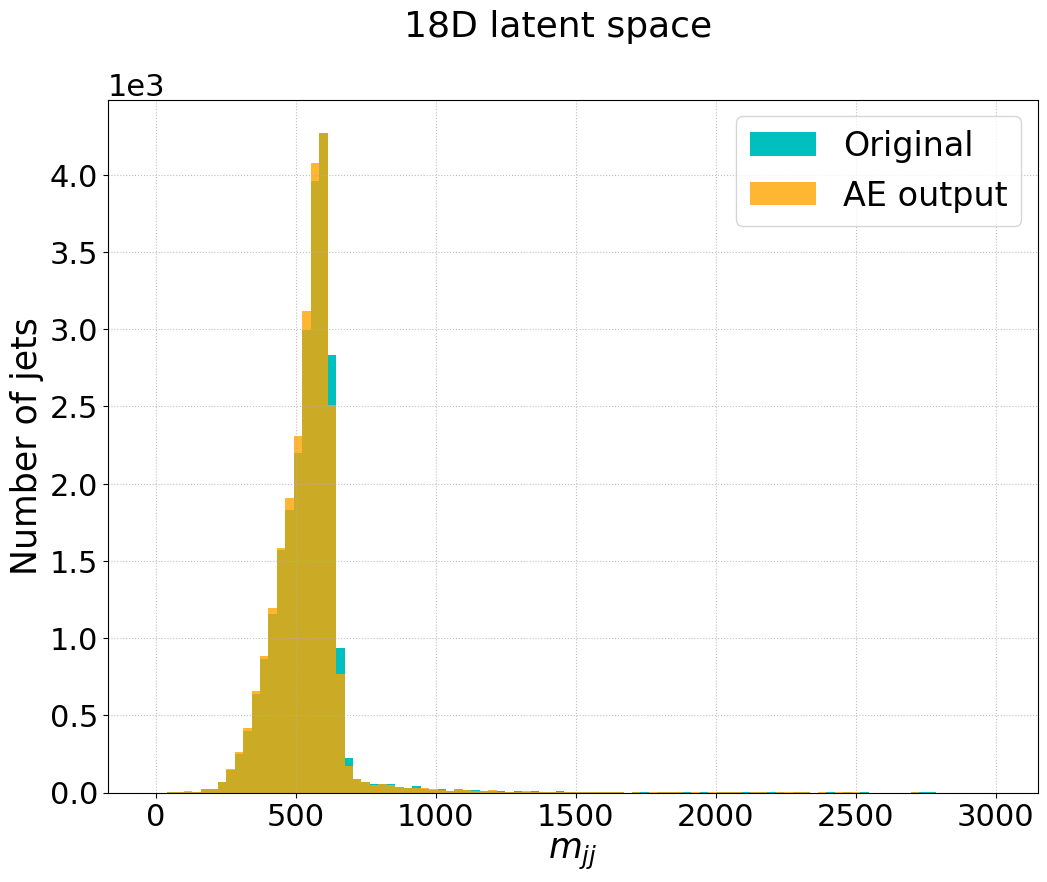

In [18]:
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

range = (-20, 3000)
n_hist_data, bin_edges, _ = plt.hist(np.array(mjj_orig_list), bins=100, color='c', label='Original', range=range, density=False)
plt.hist(np.array(mjj_z_list), bins=bin_edges, color='orange', alpha=0.8, label='AE output', range=range, density=False)
plt.legend()
plt.xlabel('$m_{jj}$')
plt.ylabel('Number of jets')
plt.suptitle('%dD latent space' % latent_dim)
plt.savefig('mjj_%d_z%d_decompressed.png' % (sample, latent_dim))
#plt.yscale('log')
ms.sciy()
plt.show()